<a href="https://colab.research.google.com/github/swilsonmfc/nlp/blob/master/NLPDoc2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Document Representations
![](https://songsforteaching.net/wp-content/uploads/2019/01/wordcloud-lyrics-1.jpg)

# Setup

In [1]:
!pip install transformers

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import random
import collections
import time
import datetime

import torch

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
from torch.utils.data import SequentialSampler

import gensim
import gensim.downloader as api
from gensim.similarities.docsim import Similarity

from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW
from transformers import BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report
from sklearn.metrics import ndcg_score

# Kaggle

In [3]:
!pip install kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

In [5]:
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

# Data

In [6]:
!kaggle datasets download -d paultimothymooney/poetry

  0% 0.00/2.00M [00:00<?, ?B/s]
100% 2.00M/2.00M [00:00<00:00, 140MB/s]


## Download

In [7]:
!ls

poetry.zip  sample_data


In [8]:
!unzip -q poetry.zip

In [9]:
!rm Kanye_West.txt kanye.txt notorious_big.txt Lil_Wayne.txt

## Artist 2 Lyrics

In [82]:
artist2lyrics = {}
artist2id = {}
id2artist = []

counter = 0
for file in glob.glob('*.txt'):
  artist = file[:-4]
  with open(file, 'r') as f:
    lyrics = f.read()

  artist2lyrics[artist] = lyrics
  artist2id[artist] = counter
  id2artist.append(artist)
  counter += 1

In [154]:
artist2lyrics['blink-182'][0:500]

"Can we forget about the things I said when I was drunk...\nI didn't mean to call you that\nI can't remember what was said\nOr what you threw at me Please tell me\nPlease tell me why\nMy car is in the front yard\nAnd I am sleeping with my cloths on\nI came in throught the window... Last night\nAnd your... Gone\nGone It's no suprise to me I am my own worst enemy\nCuz every now and then I kick the living shit out of me\nThe smoke alarm is going offf and there a cigarette\nStill buring Please tell me why\nMy car"

In [84]:
artist2id

{'adele': 22,
 'al-green': 23,
 'alicia-keys': 4,
 'amy-winehouse': 9,
 'beatles': 41,
 'bieber': 28,
 'bjork': 33,
 'blink-182': 19,
 'bob-dylan': 1,
 'bob-marley': 31,
 'britney-spears': 11,
 'bruce-springsteen': 40,
 'bruno-mars': 14,
 'cake': 36,
 'dickinson': 26,
 'disney': 37,
 'dj-khaled': 7,
 'dolly-parton': 2,
 'dr-seuss': 18,
 'drake': 43,
 'eminem': 8,
 'janisjoplin': 39,
 'jimi-hendrix': 3,
 'johnny-cash': 25,
 'joni-mitchell': 21,
 'kanye-west': 5,
 'lady-gaga': 30,
 'leonard-cohen': 38,
 'lil-wayne': 35,
 'lin-manuel-miranda': 17,
 'lorde': 12,
 'ludacris': 10,
 'michael-jackson': 32,
 'missy-elliott': 15,
 'nickelback': 20,
 'nicki-minaj': 44,
 'nirvana': 0,
 'notorious-big': 42,
 'nursery_rhymes': 16,
 'patti-smith': 24,
 'paul-simon': 27,
 'prince': 34,
 'r-kelly': 29,
 'radiohead': 13,
 'rihanna': 6}

# Corpus

In [85]:
def read_corpus(artist_lyrics, tokens_only=False):
  for artist, lyrics in artist_lyrics.items():
      tokens = gensim.utils.simple_preprocess(lyrics)
      artist_id = artist2id[artist]

      if tokens_only:
          yield tokens
      else:
          # For training data, add tags
          yield gensim.models.doc2vec.TaggedDocument(tokens, [artist_id])


def split_train_test_corpus(corpus, split=0.75):
  train = []
  test  = []

  for words, artist_id in corpus:
    train_len = int(len(words) * split)
    train_c = words[0: train_len]
    test_c  = words[train_len: ]

    train.append(gensim.models.doc2vec.TaggedDocument(train_c, artist_id))
    test.append(gensim.models.doc2vec.TaggedDocument(test_c, artist_id))
  
  return train, test

corpus = list(read_corpus(artist2lyrics))
train_corpus, test_corpus = split_train_test_corpus(corpus)

In [159]:
# Nirvana
train_corpus[0].words[0:20]

['load',
 'up',
 'on',
 'guns',
 'bring',
 'your',
 'friends',
 'it',
 'fun',
 'to',
 'lose',
 'and',
 'to',
 'pretend',
 'she',
 'over',
 'bored',
 'and',
 'self',
 'assured']

# Topic Models
* We could look to Topic Modeling
* Apply LSA or LDA 
* Settle on number of topics using Coherence metric
* Map documents to LSA / LDA space (vectorized document)
* Compare similarity 

# Word2Vec
* Approach to map a word to a low dimensional space
* Build using a language model and word co-occurence (predict words)
* Implemented using Skip-Gram or Continuous Bag of Words

![Img](https://www.researchgate.net/profile/Nailah_Al-Madi/publication/319954363/figure/fig1/AS:552189871353858@1508663732919/CBOW-and-Skip-gram-models-architecture-1.png)

## Embedding Algebra

![](https://www.researchgate.net/profile/Joshua_Peterson2/publication/316921211/figure/fig2/AS:667626124619787@1536185880504/The-parallelogram-model-of-analogy-completes-the-analogy-king-queen-man-by.png)

## Load
* We'll pull global vectors built from wiki
* This embedding represents words in 50 dimensions

In [87]:
wv = api.load('glove-wiki-gigaword-50')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## GloVe
* GloVe came out of Stanford (https://nlp.stanford.edu/pubs/glove.pdf)
* Researched what is Word2Vec optimizing
* Dramatic improvement in run time
* Similar to Word2Vec
  * Captures co-occurrence statistics
  * Distance between embeddings

# Mean of Word Embeddings
* Look up the embedding for each word in the document's corpus
* Average the unique embeddings in the document
* Builds on the algebraic properties of embeddings in word2vec

## MOWE

In [88]:
def compute_mowe(corpus):
  mowe = []

  for doc in corpus:
    bag = set()
    words = 0
    vec = None

    for word in doc.words:
      if word in bag:
        continue
      bag.add(word)

      if word in wv.vocab:
        vec = wv.word_vec(word) if vec is None else vec + wv.word_vec(word)
        words += 1

    vec = vec / words
    mowe.append(vec)
  
  return mowe

train_mowe = compute_mowe(train_corpus)
test_mowe  = compute_mowe(test_corpus)

In [89]:
train_mowe[0]

array([ 1.54950336e-01,  4.86932844e-02, -5.89837367e-03, -2.91883439e-01,
        2.88334399e-01,  6.17414564e-02, -2.34456003e-01,  9.05345753e-02,
       -7.93985054e-02,  1.10978894e-01, -7.67452344e-02,  1.35282323e-01,
       -1.06742002e-01,  4.55242582e-02,  3.58889312e-01,  2.27107227e-01,
        5.71474433e-02,  1.24719357e-02, -1.33265048e-01, -3.96098226e-01,
       -9.29171667e-02,  2.28529528e-01,  3.03278029e-01,  3.97048220e-02,
        2.74321079e-01, -1.06808078e+00, -3.62022132e-01,  2.75569260e-01,
        4.85836953e-01, -3.33712518e-01,  2.06391025e+00,  2.67924607e-01,
       -1.57810912e-01, -2.93849725e-02, -8.08097050e-02,  5.92822805e-02,
        3.92161235e-02,  1.40430881e-02,  1.35458097e-01, -2.66414702e-01,
       -1.17865518e-01,  1.59786525e-03, -3.20789032e-02,  2.25130722e-01,
        1.91300213e-01,  2.20919233e-02, -1.29248267e-02, -2.55970389e-01,
       -1.10096335e-02, -2.80430745e-02], dtype=float32)

## Similarity

In [90]:
results = []

counter = 0
for test_doc in test_mowe:
  test_doc = test_mowe[counter].reshape(1, -1)

  artist_sim = []
  for train_doc in train_mowe:
    sim = cosine_similarity(train_doc.reshape(1, -1), test_doc).squeeze()
    artist_sim.append(sim)  
  
  max = np.argmax(artist_sim)
  min = np.argmin(artist_sim)
  results.append({
      'artist' : id2artist[counter],
      'most_similar' : id2artist[max],
      'most': np.max(artist_sim),
      'least_similar' : id2artist[min],
      'least': np.min(artist_sim)
  })
  counter += 1

frame = pd.DataFrame(results)
print('Matches', np.sum(np.where(frame.artist == frame.most_similar, 1, 0)))
frame

Matches 24


,artist,most_similar,most,least_similar,least
0,nirvana,nirvana,0.997396,missy-elliott,0.954433
1,bob-dylan,dolly-parton,0.996203,dickinson,0.961341
2,dolly-parton,dolly-parton,0.998775,dickinson,0.950177
3,jimi-hendrix,janisjoplin,0.997687,dickinson,0.939707
4,alicia-keys,al-green,0.998158,dickinson,0.942114
5,kanye-west,kanye-west,0.997076,dickinson,0.924841
6,rihanna,janisjoplin,0.997364,dickinson,0.939276
7,dj-khaled,dj-khaled,0.997465,dickinson,0.935030
8,eminem,eminem,0.998251,dickinson,0.946674
9,amy-winehouse,amy-winehouse,0.998092,dickinson,0.946748


# Weighted MOWE
* A weighted average approach builds on a simple average based on bag of words
* We take the frequencies of the words in the document to weight

## W-MOWE

In [91]:
def compute_weighted_mowe(corpus):
  mowe = []

  for doc in corpus:
    vec = None
    words = 0

    for word in doc.words:
      if word in wv.vocab:
        vec = wv.word_vec(word) if vec is None else vec + wv.word_vec(word)
        words += 1

    vec = vec / words
    mowe.append(vec)
  
  return mowe

train_weighted_mowe = compute_weighted_mowe(train_corpus)
test_weighted_mowe  = compute_weighted_mowe(test_corpus)

In [92]:
train_weighted_mowe[0]

array([ 0.19559497,  0.11724761,  0.00607274, -0.26764312,  0.37272996,
       -0.00441005, -0.37493387,  0.06237694, -0.21506894,  0.08326995,
       -0.07717003,  0.25325766, -0.2991491 , -0.05970439,  0.5339159 ,
        0.28429908,  0.1188302 ,  0.03791129, -0.1660163 , -0.47083682,
       -0.1320999 ,  0.32936293,  0.36215812,  0.08034883,  0.359624  ,
       -1.5455637 , -0.4903922 ,  0.1924811 ,  0.47487378, -0.53221357,
        2.87099   ,  0.3474461 , -0.3326021 , -0.12064427, -0.04965992,
       -0.04459094,  0.107208  ,  0.05076714,  0.18876286, -0.28145605,
       -0.1556599 ,  0.07327984, -0.05377859,  0.20016786,  0.10080919,
        0.02889267, -0.07625623, -0.26759976, -0.04125334,  0.1480381 ],
      dtype=float32)

## Similarity

In [93]:
results = []

counter = 0
for test_doc in test_weighted_mowe:
  test_doc = test_weighted_mowe[counter].reshape(1, -1)

  artist_sim = []
  for train_doc in train_weighted_mowe:
    sim = cosine_similarity(train_doc.reshape(1, -1), test_doc).squeeze()
    artist_sim.append(sim)  
  
  max = np.argmax(artist_sim)
  min = np.argmin(artist_sim)
  results.append({
      'artist' : id2artist[counter],
      'most_similar' : id2artist[max],
      'most': np.max(artist_sim),
      'least_similar' : id2artist[min],
      'least': np.min(artist_sim)
  })
  counter += 1

frame = pd.DataFrame(results)
print('Matches', np.sum(np.where(frame.artist == frame.most_similar, 1, 0)))
frame

Matches 30


,artist,most_similar,most,least_similar,least
0,nirvana,eminem,0.998748,nursery_rhymes,0.982941
1,bob-dylan,bob-dylan,0.999597,nursery_rhymes,0.988499
2,dolly-parton,jimi-hendrix,0.999089,dickinson,0.981122
3,jimi-hendrix,r-kelly,0.999065,dickinson,0.976016
4,alicia-keys,bieber,0.999369,dickinson,0.966633
5,kanye-west,kanye-west,0.999645,dickinson,0.974730
6,rihanna,michael-jackson,0.999473,dickinson,0.970357
7,dj-khaled,dj-khaled,0.999566,dickinson,0.975715
8,eminem,eminem,0.999473,dickinson,0.981217
9,amy-winehouse,amy-winehouse,0.999179,dickinson,0.979417


# Doc2Vec
![](https://pbs.twimg.com/media/DdKR0ZOX4AEl_0N.jpg)


## Paragraph Vectors

### Distributed Memory
* PV-DM
* Analogous to Word2Vec CBOW
* The doc-vectors are obtained by training a neural network on the synthetic task of predicting a center word based an average of both context word-vectors and the full document’s doc-vector.

### Distributed Bag of Words 
* PV-DBOW
* PV-DBOW is analogous to Word2Vec SkipGram. 
* The doc-vectors are obtained by training a neural network on the synthetic task of predicting a target word just from the full document’s doc-vector. (It is also common to combine this with skip-gram testing, using both the doc-vector and nearby word-vectors to predict a single target word, but only one at a time.)

![](https://i.stack.imgur.com/t7slV.png)

## Gensim

In [94]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

In [95]:
model.build_vocab(train_corpus)

In [96]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [97]:
vector = model.infer_vector(['what', 'age', 'are', 'you'])
print(vector)

[-0.07568356 -0.15049233  0.11287741  0.24852103  0.0969092   0.06063254
 -0.02235721  0.13259408 -0.0823933   0.24891229  0.20082925  0.1533984
  0.0744637  -0.290309    0.16146968  0.2336377  -0.433001   -0.22919615
 -0.01352799  0.13553731 -0.0786716  -0.18435977 -0.01631516 -0.00120235
  0.30176806 -0.18565844  0.06484322  0.07710267  0.11713608  0.11530985
 -0.00547929  0.11736127  0.35931215 -0.03689464 -0.4049918  -0.01059677
  0.1968253  -0.14210048 -0.19440651 -0.11083711  0.20551889  0.26681456
 -0.06362668  0.11165347  0.02112164  0.09843384 -0.15129791 -0.17440589
 -0.1104328   0.10460387]


In [98]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [99]:
counter = collections.Counter(ranks)
print(counter)

Counter({0: 45})


In [100]:
results = []
for doc_id in range(len(test_corpus)):
  inferred_vector = model.infer_vector(test_corpus[doc_id].words)
  sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
  max = sims[0][0]

  results.append({
      'artist' : id2artist[doc_id],
      'most_similar' : id2artist[sims[0][0]],
      'most': sims[0][1],
      'least_similar' : id2artist[sims[len(sims) - 1][0]],
      'least': sims[len(sims) - 1][1]
  })
pd.DataFrame(results)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,artist,most_similar,most,least_similar,least
0,nirvana,nirvana,0.747425,dj-khaled,-0.254419
1,bob-dylan,bob-dylan,0.730770,lil-wayne,-0.139802
2,dolly-parton,dolly-parton,0.819038,nicki-minaj,-0.175378
3,jimi-hendrix,jimi-hendrix,0.869471,notorious-big,-0.110712
4,alicia-keys,bieber,0.691594,notorious-big,0.005449
5,kanye-west,kanye-west,0.939242,beatles,-0.234476
6,rihanna,rihanna,0.821656,johnny-cash,-0.212295
7,dj-khaled,dj-khaled,0.823635,patti-smith,-0.156614
8,eminem,eminem,0.786102,joni-mitchell,-0.149733
9,amy-winehouse,amy-winehouse,0.871744,lil-wayne,-0.078857


# BERT
* Another approach involves use a transformer architecture
* With a model like BERT we're:
  * Classifying a sequence
  * Reusing language understanding from the trained language model
  * Fine tuning for our particular purpose
* BERT has size limitations
  * 512 Token limit (less [CLS] and [SEP])
  * Truncate the documents to the max length 
  * Chunk the text (make multiple documents)
  * Drop middle tokens (keep beginning and end)

## Pre-Training & Fine Tuning
![](https://opendatascience.com/wp-content/uploads/2020/04/nlp7.png)

## Input
![](https://miro.medium.com/max/2348/0*m_kXt3uqZH9e7H4w.png)

## Device
* Test if CUDA is available, if so use the GPU else CPU

In [101]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('Using GPU', torch.cuda.get_device_name(0))
else:
    print('No GPU')
    device = torch.device("cpu")

Using GPU Tesla T4


## Load Model
* Load the BERT tokenizer

In [102]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

## Batch Lyrics
* Batch up the lyrics into bundles of "BATCH" size
* We create a document / training instance per batch

In [120]:
BATCH = 200
documents = []

for words, artist_id in corpus:
  for start in range(0, len(words), BATCH):
    doc = words[start: start + BATCH]
    documents.append((doc, artist_id))

print(len(documents))

5642


## Encode
* Call the tokenizer on each document
* This will return a list of dictionaries with three items in each
  * The encoded words
  * The mask of the words (present or padding)
  * The truth vector

In [121]:
X = []
y = []

for doc, artist_id in documents:
  encoded = tokenizer.encode_plus(doc, 
                                  add_special_tokens = True,
                                  pad_to_max_length=True,
                                  truncation = True,
                                  return_attention_mask=True,
                                  max_length=128)
  X.append(encoded)
  y.append(artist_id)

## Train - Test
* Split the encoded documents into train, test, validation

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

## PyTorch Tensors
* Convert the lists in X_train, X_test & X_val into Tensors

In [123]:
X_train_inputs = torch.tensor([doc['input_ids'] for doc in X_train])
X_test_inputs  = torch.tensor([doc['input_ids'] for doc in X_test])
X_val_inputs   = torch.tensor([doc['input_ids'] for doc in X_val])

y_train_labels = torch.tensor(y_train)
y_test_labels  = torch.tensor(y_test)
y_val_labels   = torch.tensor(y_val)

X_train_masks  = torch.tensor([doc['attention_mask'] for doc in X_train])
X_test_masks   = torch.tensor([doc['attention_mask'] for doc in X_test])
X_val_masks    = torch.tensor([doc['attention_mask'] for doc in X_val])

## DataSet / Data Loader
* Wrap up our tensors in a Dataset
* Apply a sampler 
  * Random for Train
  * Sequential for Test
* Return a DataLoader that pulls in batches 

In [124]:
BATCH_SIZE = 8

train_data       = TensorDataset(X_train_inputs, X_train_masks, y_train_labels)
train_sampler    = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

test_data        = TensorDataset(X_test_inputs, X_test_masks, y_test_labels)
test_sampler     = SequentialSampler(test_data)
test_dataloader  = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

val_data         = TensorDataset(X_val_inputs, X_val_masks, y_val_labels)
val_sampler      = SequentialSampler(val_data)
val_dataloader   = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE) 

## Model
* Use the Bert-uncased model
* We don't need the output of attention or hidden_state (i.e. no Decode)
* Move the model onto the GPU

In [125]:
labels = len(id2artist)
model = BertForSequenceClassification.from_pretrained (
    "bert-base-uncased", # 12-layer BERT model & uncased vocabulary
    num_labels = labels, # The number of output labels
    output_attentions = False,    # Don't return attentions weights.
    output_hidden_states = False, # Don't return all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [126]:
optimizer = AdamW(model.parameters(),
    lr  = 5e-5, # args.learning_rate - default is 5e-5.
    eps = 1e-8  # args.adam_epsilon  - default is 1e-8.
)

In [127]:
EPOCHS = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [128]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [129]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

## Training

In [130]:
SEED = 1003
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [131]:
# Average Epoch Losses
loss_values = []

# Training Loop
for epoch_i in range(0, EPOCHS):
  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
  print('Training...')

  # Measure how long the training epoch takes.
  t0 = time.time()

  # Reset the total loss for this epoch.
  total_loss = 0

  # Training mode
  model.train()

  # For each batch of training data...
  for step, batch in enumerate(train_dataloader):

    # Progress update every 100 batches.
    if step % 20 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

    # Use the dataloader to grab a batch
    # Unpack into "b_" batch variables
    #   input ids 
    #   attention masks
    #   labels 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Clear previous gradients 
    model.zero_grad()        

    # Forward pass 
    outputs = model(b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask, 
                labels=b_labels)
    
    # Take loss from the forward pass output
    loss = outputs[0]

    # Accumulate the training loss 
    total_loss += loss.item()

    # Backward pass / calc gradients.
    loss.backward()

    # Clip gradients -- Prevent "exploding gradients"
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters (i.e. weights)
    # Step using the gradient.
    optimizer.step()

    # Update the learning rate with our scheduler
    scheduler.step()

  # Calculate the average loss over the training data.
  avg_train_loss = total_loss / len(train_dataloader)            
  
  # Store the loss value for plotting the learning curve.
  loss_values.append(avg_train_loss)

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training Epoch took: {:}".format(format_time(time.time() - t0)))
      
  # Validation
  print("")
  print("Running Validation...")

  t0 = time.time()

  # Evaluation mode
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in val_dataloader:    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        
      outputs = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask)
    
    # Get the "logits" output by the model. The "logits" are the output
    # values prior to applying an activation function like the softmax.
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Calculate the accuracy for this batch 
    # Flat_accuracy = flattened
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    # Accumulate 
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches
    nb_eval_steps += 1

  # Final accuracy
  print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("  Validation took: {:}".format(format_time(time.time() - t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    20  of    397.    Elapsed: 0:00:05.
  Batch    40  of    397.    Elapsed: 0:00:09.
  Batch    60  of    397.    Elapsed: 0:00:14.
  Batch    80  of    397.    Elapsed: 0:00:18.
  Batch   100  of    397.    Elapsed: 0:00:23.
  Batch   120  of    397.    Elapsed: 0:00:28.
  Batch   140  of    397.    Elapsed: 0:00:32.
  Batch   160  of    397.    Elapsed: 0:00:37.
  Batch   180  of    397.    Elapsed: 0:00:41.
  Batch   200  of    397.    Elapsed: 0:00:46.
  Batch   220  of    397.    Elapsed: 0:00:50.
  Batch   240  of    397.    Elapsed: 0:00:55.
  Batch   260  of    397.    Elapsed: 0:00:59.
  Batch   280  of    397.    Elapsed: 0:01:04.
  Batch   300  of    397.    Elapsed: 0:01:08.
  Batch   320  of    397.    Elapsed: 0:01:13.
  Batch   340  of    397.    Elapsed: 0:01:17.
  Batch   360  of    397.    Elapsed: 0:01:22.
  Batch   380  of    397.    Elapsed: 0:01:26.

  Average training loss: 3.54
  Training Epoch took: 0:01:30

R

## Plot

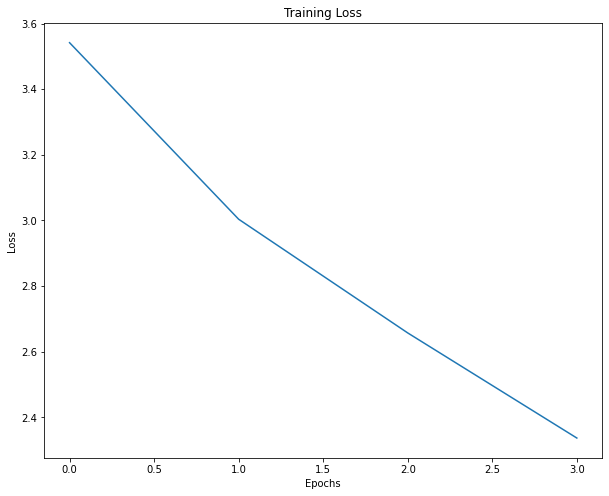

In [142]:
plt.figure(figsize=(10,8))
plt.plot(loss_values)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');

## Test

In [147]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Measure elapsed time.
t0 = time.time()

# Predict 
for (step, batch) in enumerate(test_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Progress update every 100 batches.
    if step % 20 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))


    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)


  Batch    20  of    177.    Elapsed: 0:00:01.
  Batch    40  of    177.    Elapsed: 0:00:03.
  Batch    60  of    177.    Elapsed: 0:00:04.
  Batch    80  of    177.    Elapsed: 0:00:06.
  Batch   100  of    177.    Elapsed: 0:00:07.
  Batch   120  of    177.    Elapsed: 0:00:09.
  Batch   140  of    177.    Elapsed: 0:00:10.
  Batch   160  of    177.    Elapsed: 0:00:12.


In [148]:
predictions = np.concatenate(predictions, axis=0)
predictions_class = np.argmax(predictions, axis=1)

true_labels_agg = np.concatenate(true_labels, axis=0)
true_labels_class = true_labels_agg.T.squeeze()

## Accuracy

In [137]:
print(classification_report(true_labels_class, predictions_class, target_names=id2artist))

                    precision    recall  f1-score   support

           nirvana       0.00      0.00      0.00        13
         bob-dylan       0.22      0.76      0.33        49
      dolly-parton       0.00      0.00      0.00        23
      jimi-hendrix       0.00      0.00      0.00        20
       alicia-keys       0.00      0.00      0.00        34
        kanye-west       0.39      0.79      0.52        61
           rihanna       0.00      0.00      0.00        34
         dj-khaled       0.30      0.17      0.22        41
            eminem       0.34      0.73      0.47        82
     amy-winehouse       0.00      0.00      0.00        20
          ludacris       0.38      0.34      0.36        53
    britney-spears       0.12      0.23      0.15        31
             lorde       0.00      0.00      0.00        16
         radiohead       0.00      0.00      0.00        13
        bruno-mars       0.00      0.00      0.00        36
     missy-elliott       0.68      0.50

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
